In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import glob
from matplotlib.gridspec import GridSpec

# ---
thisrun = "testrun_02_gbas_field_tau10p0"
outdir = "/home/tykukla/SCEPTER/scepter_output"

In [33]:
# --- FUNCTION to preprocess .txt files for consistent delimiters
def preprocess_txt(file_path):
    data = []  # Initialize a list to store the processed data

    # Initialize a flag to determine if we are reading the header
    is_header = True

    # Read the file line by line and process the data
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if is_header:
                # Split the first line into column names
                column_names = re.split(r'\s+', line)
                is_header = False
            else:
                # Split the other lines into data values
                values = re.split(r'\s+', line)
                data.append(values)

    # Create a DataFrame with the processed data and set column names
    df = pd.DataFrame(data, columns=column_names)
    # return
    return df

In [34]:
# --- read in profile data
# profile data have one file per timestep, so we must read each in separately and combine

# where results are stored
results_path = os.path.join(outdir, thisrun)
flx_path, prof_path = os.path.join(results_path, "flx"), os.path.join(results_path, "prof")

# define file name pattern
fn_pref = ["prof_aq", "prof_sld(wt%)"]
fn_ext = ".txt"

# loop through variables
df = pd.DataFrame()  # initialize empty df to store dat
for var in fn_pref:
    # set pattern
    fn_pattern = f"{var}-*{fn_ext}"
    # get list of filenames
    file_paths = glob.glob(f"{prof_path}/{fn_pattern}")
    file_paths_numsOnly = [path for path in file_paths if re.search(r'\d', path.split("/")[-1])]
    # filter edge case of "prof_aq-DIC-020.txt"
    if 'prof_aq-DIC-020.txt' in file_paths_numsOnly:
        file_paths_numsOnly=file_paths_numsOnly.remove('prof-restart')
    # read in data and concatenate
    for file_path in file_paths_numsOnly:
        dfi = preprocess_txt(file_path)
        # apply pd.to_numeric to all columns using the "map" method
        dfi = dfi.map(pd.to_numeric)
        # add var
        dfi["var"] = var
        # combine
        df = pd.concat([df, dfi], ignore_index=True)


# sort by time and depth
df = df.sort_values(by=["var", "time", "z"])
df

,z,ca,k,mg,na,no3,ph,time,var,8.333333333333333218e-03,3.931103090854828029e-03,gbas,inrt,g2,amnt
90,0.008333,0.000098,1.059363e-13,4.294129e-13,1.249617e-11,0.000018,7.061269,0.000084,prof_aq,NaN,NaN,NaN,NaN,NaN,NaN
91,0.025000,0.000377,2.822727e-18,1.466338e-17,1.746802e-15,0.000032,6.765357,0.000084,prof_aq,NaN,NaN,NaN,NaN,NaN,NaN
92,0.041667,0.000567,7.062328e-21,5.032049e-21,2.860484e-19,0.000045,6.677091,0.000084,prof_aq,NaN,NaN,NaN,NaN,NaN,NaN
93,0.058333,0.000721,7.892656e-21,6.101502e-21,1.779554e-19,0.000058,6.624841,0.000084,prof_aq,NaN,NaN,NaN,NaN,NaN,NaN
94,0.075000,0.000851,8.577283e-21,7.205405e-21,8.655587e-21,0.000072,6.588649,0.000084,prof_aq,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,0.425000,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,prof_sld(wt%),NaN,NaN,9.743398e-19,100.0,6.603667e-21,5.579770e-23
1135,0.441667,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,prof_sld(wt%),NaN,NaN,9.743903e-19,100.0,1.802304e-20,5.579770e-23
1136,0.458333,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,prof_sld(wt%),NaN,NaN,9.745385e-19,100.0,4.918935e-20,5.579770e-23
1137,0.475000,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,prof_sld(wt%),NaN,NaN,9.753674e-19,100.0,1.342499e-19,3.047197e-22


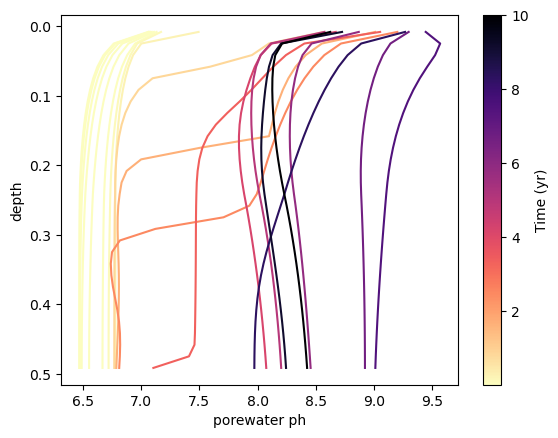

In [35]:
# --- plot depth profile of calcite through time
dfx = df[df['var'] == "prof_aq"]
# Group the DataFrame by the 'time' column
grouped = dfx.groupby('time')

# Create a colormap
cmap = plt.get_cmap('magma')  # Get the colormap
cmap = cmap.reversed()   # flip colormap
# -- no log normalization
norm = plt.Normalize(df['time'].min(), df['time'].max())  # Normalize time values for colormap
# -- log normalization WIP
# log_time = np.log(df['time'])
# norm = plt.Normalize(log_time.min(), log_time.max())  # Normalize time values for colormap

# Create a plot for each time step
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group['ph'], group['z'], color=color, label=None)
    # plt.plot(group['gt'], group['z'], color=color, linestyle='dashed', label=None)

# Add labels and a legend
plt.xlabel('porewater ph')
plt.ylabel('depth')

# Create a colorbar based on the Viridis colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array for the colorbar data
cbar = plt.colorbar(sm, label='Time (yr)', ax=plt.gca())

# flip y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [36]:
# --- CLIMATE CHECK
# --- function to preprocess clim .in files
def read_cust_delim_file(file_path):
    # Read the first line to get column names using '/'
    with open(file_path, 'r') as file:
        columns = file.readline().strip().split(' / ')

    # Read the rest of the file using '\t' as the data delimiter
    df = pd.read_table(file_path, names=columns, delimiter='\t', skiprows=[0])

    # --- clean up column names
    # Remove "# " prefix from column headers
    df.columns = df.columns.str.replace("# ", "")
    # Replace parentheses with underscores 
    df.columns = map(lambda x: x.replace('(', '_').replace(')', ''), df.columns)
    # replace "/" with underscores
    df.columns = map(lambda x: x.replace('/', '_'), df.columns)
    # remove leading or trailing spaces
    df.columns = df.columns.str.strip()
    # return
    return df

In [37]:
# --- read in data
fnvars = ["T", "q", "Wet"]
fnsuff = "_temp.in"

# loop through vars
dfclim = pd.DataFrame()
for var in fnvars:
    thisvar = var + fnsuff
    dfi = read_cust_delim_file(os.path.join(results_path, thisvar))
    # bring together
    if var == fnvars[0]:
        dfclim = dfi.copy()
    else:
        dfclim = pd.merge(dfclim, dfi, on='time_yr', how='outer')

dfclim

,time_yr,T_C,runoff_mm_month,moisture_mm_m
0,0.000000,-14.118158,7.331076,348.818412
1,0.083333,-9.115721,36.386386,349.999180
2,0.166667,-7.199803,105.622162,359.231414
3,0.250000,4.684758,258.038904,378.908079
4,0.333333,15.202311,89.786018,337.040052
...,...,...,...,...
1027,85.583333,20.846833,64.552093,281.732984
1028,85.666667,12.410568,80.873501,305.494794
1029,85.750000,6.001521,85.516014,342.041358
1030,85.833333,-0.073304,107.668845,363.014079


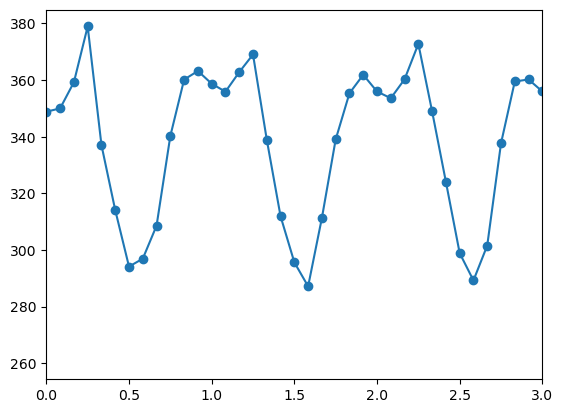

In [38]:
# --- quick plot, a few seasons
pvar = "moisture_mm_m"   # runoff_mm_month
               # T_C
               # moisture_mm_m

# plot 
plt.plot(dfclim['time_yr'], dfclim[pvar])
plt.scatter(dfclim['time_yr'], dfclim[pvar])
plt.xlim([0,3])
plt.show();

In [39]:
# --- flux data
results_path = outdir
results_dir = {"test": thisrun}
# define file name pattern
# fn_pref = ["int_flx_co2sp", "flx_co2sp" "int_flx_gas", "flx_gas"]   # will read in all species unless fn_varInclude is defined
fn_pref = ["flx_gas-pco2"]   # will read in all species unless fn_varInclude is defined
fn_varInclude = []
varCheck = True if len(fn_varInclude) > 0 else False
fn_ext = ".txt"

# loop through runs
df = pd.DataFrame()  # initialize empty df to store dat
for key, run in results_dir.items():
    # get these paths
    flx_path, prof_path = os.path.join(results_path, run, "flx"), os.path.join(results_path, run, "prof")

    # loop through variables
    for fset in fn_pref:
        # set pattern
        fn_pattern = f"{fset}*{fn_ext}"
        # get list of filenames
        file_paths = glob.glob(f"{flx_path}/{fn_pattern}")

        # read in data and concatenate
        for file_path in file_paths:
            # get the variable 
            varpattern = re.escape(fset) + r'(.*?).txt'
            varmatch = re.search(varpattern, file_path)
            var = varmatch.group(1)
            # skip this step if it's not in the include arr
            if varCheck:
                if var not in fn_varInclude:
                    continue
            # read in
            dfi = preprocess_txt(file_path)
            # apply pd.to_numeric to all columns using the "map" method
            dfi = dfi.map(pd.to_numeric)
            # add set, var, and key
            dfi["set"] = fset
            dfi["var"] = var
            dfi["run_id"] = key
            # combine
            df = pd.concat([df, dfi], ignore_index=True)

# sort by time and depth
df = df.sort_values(by=["var", "time"])
df

,time,tflx,adv,dif,rain,gbas,inrt,g2,amnt,res,set,var,run_id
0,1.000000e-19,416.333634,0.319713,39.529599,0.0,0.0,0.0,-24.767370,0.0,4.314156e+02,flx_gas-pco2,,test
1,8.433333e-05,-110.151306,0.320093,134.598582,0.0,0.0,0.0,-24.767370,0.0,-5.607454e-13,flx_gas-pco2,,test
2,2.510000e-04,-97.888969,0.321254,122.335085,0.0,0.0,0.0,-24.767370,0.0,-1.055013e-13,flx_gas-pco2,,test
3,8.343333e-04,-75.925708,0.314715,100.378363,0.0,0.0,0.0,-24.767370,0.0,1.574990e-14,flx_gas-pco2,,test
4,2.501000e-03,-51.896806,0.263320,76.400855,0.0,0.0,0.0,-24.767368,0.0,1.160507e-14,flx_gas-pco2,,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,9.675000e+00,-4.070908,24.220266,0.956614,0.0,0.0,0.0,-21.105972,0.0,-2.464742e-14,flx_gas-pco2,,test
180,9.758333e+00,-15.229487,27.057467,9.255155,0.0,0.0,0.0,-21.083135,0.0,-2.436616e-14,flx_gas-pco2,,test
181,9.841667e+00,-12.193265,19.859334,13.395654,0.0,0.0,0.0,-21.061723,0.0,-1.481084e-14,flx_gas-pco2,,test
182,9.925000e+00,-4.320697,10.307127,15.055029,0.0,0.0,0.0,-21.041458,0.0,8.803119e-16,flx_gas-pco2,,test


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


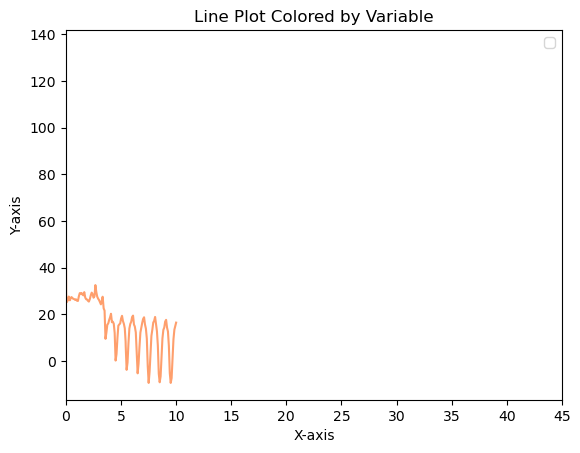

In [40]:
# --- plot CDR per year (lines colored by the set)
cdvar = "dif"    # variable to plot

# aesthetics
logX = False
logY = False
mycmap = "magma"   # name of colormap
# cmap start and end percentages
start_percentage = 0.2
end_percentage = 0.8

# ax limits
xmin, xmax = 0,45

# colormap
cmap = plt.get_cmap(mycmap)  # Get the colormap
cmap = cmap.reversed()   # flip colormap
# -- no log normalization
norm = plt.Normalize(df['time'].min(), df['time'].max())  # Normalize time values for colormap


# --- PLOT
# Create a plot for each time step
# split by set
plt.plot(df['time'], df[cdvar], color=cmap(0.2), linestyle="-")

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
if logX:
    plt.xscale('log')
    plt.xlim([0.1, 100])
if logY:
    plt.yscale('log')
    plt.ylim([0.0001, 15])
plt.title('Line Plot Colored by Variable')
plt.xlim([xmin, xmax])
# Add legend
plt.legend()
plt.show();